<a href="https://colab.research.google.com/github/weasel-codes/music-classification/blob/main/Music_Genre_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Steps to Follow
* Create Waveform
* fft > spectrum
* stft > spectrogram
* MFCC

In [1]:
import librosa, librosa.display as display
import matplotlib.pyplot as plt
import numpy as np

In [2]:
file = "/content/drive/MyDrive/ML/rock/rock.00000.wav"

## Waveform

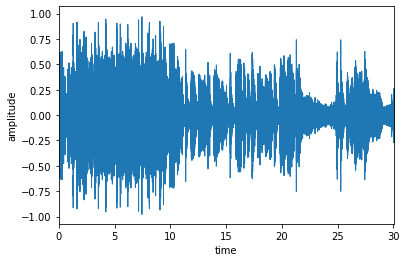

Signal size :  (661794,) , first value :  -0.033447266


In [3]:
#signal is one dimensioanl numpy array and contains no of values equal to sample_rate*duration -> 22050*30 = 6000values
#each value of signal gives amplitude of waveform
signal, sr = librosa.load(file, sr=22050)
display.waveplot(signal, sr=sr)
plt.xlabel("time")
plt.ylabel("amplitude")
plt.show()

print("Signal size : ", signal.shape, ", first value : ", signal[0])

## FFT > Spectrum

first value of fft :  (56.98974609375004-1.7763568394002505e-14j)
first value of magnitude :  56.98974609375004


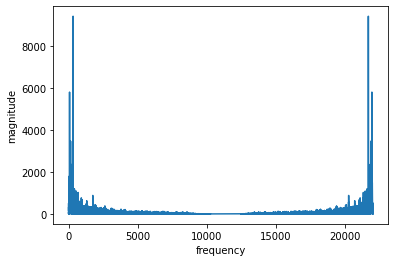

first value of frequency :  0.0


In [4]:
# We need to move from time domain to frequency domain (Frequency = 1/T)
# for this we need to create a Fast fourier Transform
# fft has same value as in total sample values aka signal
fft = np.fft.fft(signal)
print("first value of fft : ", fft[0])

# we need to find absolute values of complex values
# magnitude indicates contribution of each frequency to the sample
magnitude = np.abs(fft)
print("first value of magnitude : ", magnitude[0])

# find no. of evenly spaced numbers in an interval
frequency = np.linspace(0, sr, len(magnitude)) 
plt.plot(frequency, magnitude) # Gives us power spectrum
plt.xlabel("frequency")
plt.ylabel("magnitude")
plt.show()
print("first value of frequency : ", frequency[0])
# These two together tells us how much each frequency is contributing to the sample

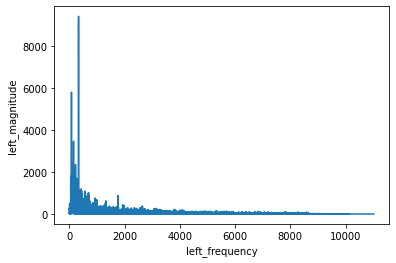

In [5]:
# Above is a symmetric graph but we only need half of it
left_frequency = frequency[:int(len(frequency)/2)]
left_magnitude = magnitude[:int(len(magnitude)/2)]
plt.plot(left_frequency, left_magnitude) # Gives us power spectrum
plt.xlabel("left_frequency")
plt.ylabel("left_magnitude")
plt.show()

## Stft > Spectrogram
* Problem spectrum = static snapshot > not getting whole sound

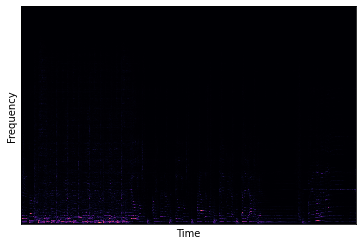

In [6]:
# Spectrogram gives us info of amplitude as function of frequency and time
n_fft = 2048 # no. of smaples per fft > Size of window for single fft
hop_length = 512 # amount of shifting we are doing to fft 
stft = librosa.core.stft(signal, n_fft=n_fft, hop_length=hop_length)
spectrogram = np.abs(stft) # complex numbers to absolute values
librosa.display.specshow(spectrogram, sr=sr, hop_length=hop_length) # Gives us spectrum
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show() # Amplitude as a function of time and frequecny

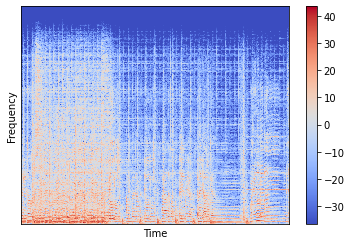

First Log Spectrum value : [  8.415056    -4.335116     3.4518528  ... -29.82491      0.42961282
   3.2210164 ]


In [11]:
# We have spectrogram with max frequencies with very less amplitudes
# At bottom we have some frequencies.
# To visualize them better : logratihmic spectrogram
log_spectrogram = librosa.amplitude_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length) # Gives us spectrum
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show() # Amplitude as a function of time and frequecny
# Plot is somewhat similar to original amplitude/time plot
print("First Log Spectrum value :", log_spectrogram[0])

## Extract MFCC

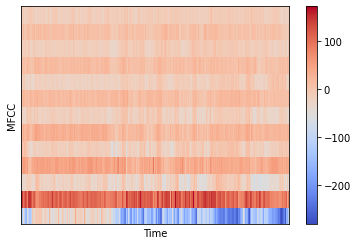

First MFCC value : [-211.65758906 -163.34107336 -109.84716095 ... -170.24191049 -135.8255985
 -110.03294443]


In [10]:
# n_mfcc = no. of coefficient we want to extract
# n_fft is used to perform short term fourier transform
MFCC = librosa.feature.mfcc(signal, n_fft=n_fft, hop_length=hop_length, n_mfcc = 13)
librosa.display.specshow(MFCC, sr=sr, hop_length=hop_length) # Gives us spectrum
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.colorbar()
plt.show()
print("First MFCC value :", MFCC[0])
# Gives idea of how MFCC are evolving over time